In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import pickle
import re
import json

# Part 1 - Setup
First we find all the words that are present within the sentiment analyzer lexicon.


In [5]:
sid = SentimentIntensityAnalyzer()
exps = list(sid.lexicon.keys())

Then cut the list to only include pronounceable words.

In [7]:
start_index = exps.index("abandon")
end_index = exps.index("zealous")
words = exps[start_index:end_index + 1]
print(f"Number of words we can work with: {len(words)}")

Number of words we can work with: 7049


We are left with over 7000 words to choose from.
We now pack them into a txt file and feed the text file into the ***CMU phonetic analyzer.***
The tool can be found at this link: http://www.speech.cs.cmu.edu/tools/lextool.html

In [8]:
# We are left with over 7000 words to choose from.
# We now pack them into a txt file and feed the text file into the CMU phonetic analyzer.
with open("raw.txt", 'w') as file:
    for word in words:
        file.write(word + "\n")

The phonetic pronunciations of these words are now located in phonetic.txt.
We need to do some data tidying in order to streamline this process. Let's feed the data into two arrays, one containing the word, and the other containing the pronunciation

We override the words array, as it will now need to contain duplicates for duplicate pronunciations.

In [9]:
words = []
sounds = []
sents = []

In [12]:
with open(r"phonetic.txt", 'r') as file:
    line = file.readline()
    while not line == "":
        split_line = line.split('\t')
        word = str.lower(split_line[0].split('(')[0])
        sound = split_line[1].split('\n')[0].split(" ")
        sentiment = sid.polarity_scores(word)['compound']

        words.append(word)
        sounds.append(sound)
        sents.append(sentiment)

        line = file.readline()

We have the word, the corresponding pronunciation, and the sentiment score all together.

Let's export this into a CSV for future analysis.

In [11]:
df = pd.DataFrame({"words": words, "sounds": sounds, "sents": sents})
df.to_csv(r"T3000_Sounds_Sentimized.csv")

# Part 2 - Data Tidying

The initialization is now complete.

Now we move onto creating a neural network model based on the data.
Let's enumerate the phonetic data into integers. They will be stored in enum_sounds.


In [20]:
flattened_sounds = [element for sublist in sounds for element in sublist]
unique_sounds = sorted(pd.unique(flattened_sounds))
NUM_SOUNDS = len(unique_sounds)

# Creating a dictionary translator to make generating the new list easier.
translator = {}
for index, sound in enumerate(unique_sounds):
    translator[sound] = index

# Transposing the old sounds into the new list.
numerical_sounds = []
for seq in sounds:
    new_seq = [translator[sound] for sound in seq]
    # counter = [new_seq.count(index) for index in range(NUM_SOUNDS)]
    numerical_sounds.append(new_seq)
    # enum_sounds.append(counter)

In [21]:
enum_sounds = []
for seq in numerical_sounds:
    counter = [seq.count(index) for index in range(NUM_SOUNDS)]
    enum_sounds.append(counter)

# Part 3 - Machine Learning

Excellent! Now we can begin the ML fun stuff!

In [16]:
import numpy as np
import tensorflow as ts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [22]:
subset = 100000
phonetic_data = np.array(enum_sounds[:subset]) # Giving the option to use a subset of the data.
np_sents = np.array(sents[:subset])
X_train, X_test, y_train, y_test = train_test_split(phonetic_data, np_sents, test_size=0.1) # Keeping the test size smaller because there's not an abudance of data

Now let's define the model

In [25]:

model_N = ts.keras.models.Sequential()
model_N.add(Dense(64, input_shape=(NUM_SOUNDS,), activation='relu'))
model_N.add(Dense(128, activation='relu'))
model_N.add(Dense(32, activation='relu'))
model_N.add(Dense(1))

model_N.compile(loss='mean_squared_error', optimizer='adam')

model_N.fit(X_train, y_train, epochs=10, batch_size=1)

loss = model_N.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", loss)

Epoch 1/10


A:\Applications\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13518/13518 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.1385
Epoch 2/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.1013
Epoch 3/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0769
Epoch 4/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0624
Epoch 5/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0526
Epoch 6/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0450
Epoch 7/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0393
Epoch 8/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0352
Epoch 9/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0329
Epoch 10/10
13518/13518 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0298
Test Loss: 0.044106438755989075


Neural networks seem to be overfitting to the data a bit, as the test loss is signficantly higher than the training loss.
Now let's save the model into a pickle file

In [26]:
import pickle

with open(r"neural_model.pkl", "wb") as f:
    pickle.dump(model_N, f)

The structure of a **decision tree** more accurately conveys the structure beheind sound combinations producing a sentiment. Let's use it instead!

In [27]:
# The structure of a decision tree more accurately conveys the structure beheind sound combinations producing a sentiment.
# Let's use it instead!
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

In [28]:
# Initialize the RandomForestRegressor
model_F = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the model
model_F.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [29]:
# Make predictions
y_pred = model_F.predict(X_test)

pred_cat = np.array([pred > 0 for pred in y_pred])
test_cat = np.array([test > 0 for test in y_test])

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
acc = accuracy_score(test_cat, pred_cat)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Accuracy: {acc}')

Mean Squared Error: 0.016514786862632212
Mean Absolute Error: 0.08611533678031288
Accuracy: 0.9647137150466045


Excellent! The Random Forests has significantly less error!
It's also ***96.5% accurate*** at guessing positive or negative sentiment! Wow!
Let's also save the model into a pickle file

In [30]:
# Excellent! The Random Forests has significantly less error!
# It's also 96.5% accurate at guessing positive or negative sentiment! Wow!
# Let's also save the model into a pickle file
import pickle

with open(r"RF_model.pkl", "wb") as f:
    pickle.dump(model_F, f)

# Part 4 - Testing / Visualization

Now let's see what the models have to say about some test data.
I isolate each sound by itself and predict its sentiment with both models.

In [31]:
test_data = np.array([[int(i == j) for i in range(NUM_SOUNDS)] for j in range(NUM_SOUNDS)])
predictions_F = model_F.predict(test_data)
predictions_N = model_N.predict(test_data)
difference = mean_squared_error(predictions_F, predictions_N)
print(difference)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0.03620864223704409


Awesome! The two models seem to be somewhat consistent with each other. I will use the random forests model for analysis, however.

In [33]:
# A couple of definitions
decoder = {value: key for key, value in translator.items()}
categories = list(decoder.values())

Instead of seeing all the results, I'm usually interested in the top and bottom figures. 
Let me write a function to extract only the top and bottom n results.

In [70]:
import operator

def n_top_bot(ordered_values, n):
    sorted_values = sorted(ordered_values)
    sorted_categories = [k for k, v in sorted(zip(categories, ordered_values), key=operator.itemgetter(1))]
    bot_7_imp = sorted_values[:n]
    bot_7_cat = sorted_categories[:n]
    top_7_imp = sorted_values[-n:]
    top_7_cat = sorted_categories[-n:]
    
    return (bot_7_cat + top_7_cat, bot_7_imp + top_7_imp)

Let's see which sounds the random forest model finds important to determine sentiment:

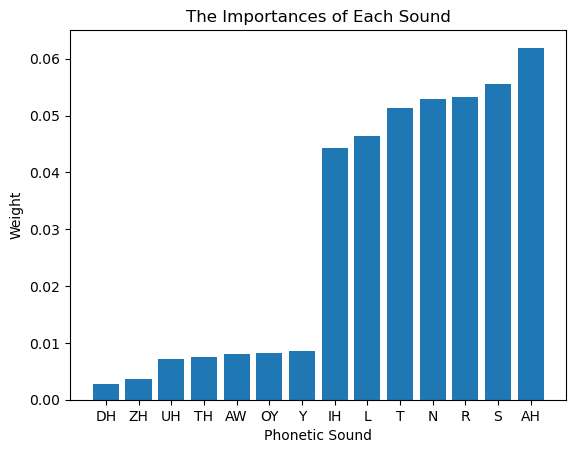

In [61]:
importances = model_F.feature_importances_

cats, imps = n_top_bot(importances, 7)

plt.bar(cats, imps)
plt.ylabel("Weight")
plt.xlabel("Phonetic Sound")
plt.title("The Importances of Each Sound")
plt.show()

Now, to find an answer to our question, I'm going to test what the sentimental importance of a certain sound was.
To do this, I'm going to go through our list of words, and see the change in sentiment prediction when I remove that word

In [ ]:
# Now, to find an answer to our question, I'm going to test what the sentimental importance of a certain sound was.
# To do this, I'm going to go through our list of words, and see the change in sentiment prediction when I remove that word
total_sents = np.zeros(NUM_SOUNDS)
counts = np.zeros(NUM_SOUNDS)

for sound in enum_sounds:
    original_sent = model_F.predict([sound])[0]
    for i in range(NUM_SOUNDS):
        # If the sound is present, remove it and see the result.
        if sound[i] == 0: continue
        
        sound[i] -= 1
        new_sent = model_F.predict([sound])[0]
        delta_sent = new_sent - original_sent
        total_sents[i] += delta_sent
        counts[i] += 1
        sound[i] += 1
            
avg_sent_changes = total_sents / counts

Awesome, now let's graph the results:

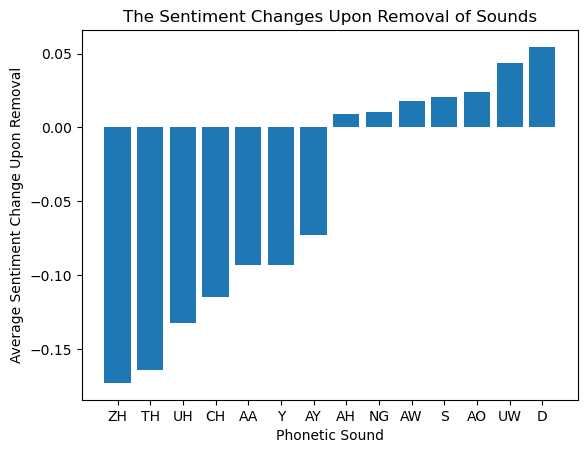

In [72]:
cats, results = n_top_bot(avg_sent_changes, 7)
plt.bar(cats, results)
plt.ylabel("Average Sentiment Change Upon Removal")
plt.xlabel("Phonetic Sound")
plt.title("The Sentiment Changes Upon Removal of Sounds")
plt.show()

With that, my basic model is complete. I'll test it on full texts in the Processor lab file. Let's test it on a negative word that was not present within the training dataset: **gone**

In [76]:
test_word = np.zeros(NUM_SOUNDS)
test_word[14] = 1
test_word[2] = 1
test_word[22] = 1

# gone
model_F.predict(np.array([test_word]))

array([-0.324306])

Very negative, and very good! This is a solid proof-of-concept that can be expanded upon through the incorpotation of live audio data.